In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionResNetV2,InceptionV3, VGG16,VGG19,ResNet50V2
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
import sys
sys.argv[1:]
sys.argv[1:] = '-d dataset -p plot -m model'.split()

In [3]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str, default="covid19.model",help="path to output loss/accuracy plot")

args = vars(ap.parse_args())

In [4]:
INIT_LR = 1e-3
EPOCHS = 24
BS = 12
IMG_SIZE=224

In [5]:
#loading and preprocessing images
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)

In [6]:
print(len(labels))
print(len(data))

875
875


In [7]:
# encoding on the label
for idx, x in np.ndenumerate(labels):
   if x=='covid':
    labels[idx]=0
   if x=='pnemonia_virus':
    labels[idx]=1
   if x=='pnemonia_bacteria':
    labels[idx]=2
   if x=='normal':
    labels[idx]=3


In [8]:
labels= labels.astype(np.integer)

In [9]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [10]:
print(len(data))
data.ndim

875


4

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
print(len(trainX))
print(len(testX))
print(len(trainY))
print(len(testY))

700
175
700
175


In [12]:
testY

array([0, 0, 3, 3, 0, 1, 2, 3, 2, 3, 3, 1, 0, 3, 2, 2, 2, 3, 3, 2, 0, 2,
       3, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 3, 2, 2, 2, 1, 3, 1, 2, 0,
       1, 3, 1, 1, 1, 3, 2, 0, 3, 3, 2, 0, 3, 2, 1, 2, 0, 0, 2, 2, 0, 3,
       1, 1, 3, 0, 2, 3, 2, 2, 2, 0, 1, 2, 3, 2, 1, 2, 3, 1, 3, 2, 3, 3,
       0, 1, 3, 2, 1, 3, 1, 3, 3, 2, 0, 3, 0, 0, 1, 0, 1, 0, 3, 0, 3, 0,
       0, 1, 1, 0, 0, 3, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 3, 1, 3,
       0, 2, 1, 3, 2, 0, 0, 2, 0, 3, 0, 1, 3, 2, 3, 0, 3, 3, 0, 2, 0, 0,
       1, 2, 3, 2, 3, 3, 3, 0, 0, 1, 2, 3, 0, 0, 1, 1, 3, 1, 1, 3, 1])

In [13]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [14]:
## load the network ensuring the head FC layer sets are left off
baseModel= VGG16(weights='imagenet', include_top=False,

input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE,3)), )

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(4, activation="sigmoid")(headModel)

model_2 = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
for layer in baseModel.layers:
    layer.trainable = False

In [16]:
# compile our model
print("compiling model...")
opt = Adam(lr=0.001, decay=INIT_LR/25)
model_2.compile(loss="SparseCategoricalCrossentropy", optimizer=opt,
metrics=["accuracy"])

# train the head of the network
print("training head...")
import math
checkpoint = ModelCheckpoint("vgg_model.hdf5", monitor='loss', verbose=1,
                             save_best_only=True, mode='auto', period=1)
H = model_2.fit_generator(
trainAug.flow(trainX, trainY, batch_size=BS),
steps_per_epoch=math.floor(len(trainX)/BS),
validation_data=(testX, testY),
validation_steps=math.floor(len(testX)/BS), epochs=35,
callbacks=[checkpoint])

compiling model...
training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/35
58/58 [==============================] - ETA: 0s - loss: 1.3892 - accuracy: 0.3190
Epoch 00001: loss improved from inf to 1.38925, saving model to vgg_model.hdf5
58/58 [==============================] - 161s 3s/step - loss: 1.3892 - accuracy: 0.3190 - val_loss: 1.2827 - val_accuracy: 0.5543
Epoch 2/35
58/58 [==============================] - ETA: 0s - loss: 1.2147 - accuracy: 0.5000
Epoch 00002: loss improved from 1.38925 to 1.21473, saving model to vgg_model.hdf5
58/58 [==============================] - 168s 3s/step - loss: 1.2147 - accuracy: 0.5000 - val_loss: 1.0886 - val_accuracy: 0.6000
Epoch 3/35
58/58 [==============================] - ETA: 0s - loss: 1.1041 - accuracy: 0.5203
Epoch 00003: loss improved from 1.21473 to 1.10414, saving model to vgg_model.hdf5
58/58 [==============================] - 175s 3s/step - loss: 1.1041 - accuracy: 0.5203 - val_loss: 0

Epoch 27/35
58/58 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.7922
Epoch 00027: loss did not improve from 0.50527
58/58 [==============================] - 143s 2s/step - loss: 0.5058 - accuracy: 0.7922 - val_loss: 0.4415 - val_accuracy: 0.7943
Epoch 28/35
58/58 [==============================] - ETA: 0s - loss: 0.4734 - accuracy: 0.8081
Epoch 00028: loss improved from 0.50527 to 0.47342, saving model to vgg_model.hdf5
58/58 [==============================] - 146s 3s/step - loss: 0.4734 - accuracy: 0.8081 - val_loss: 0.4448 - val_accuracy: 0.8229
Epoch 29/35
58/58 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8241
Epoch 00029: loss improved from 0.47342 to 0.46072, saving model to vgg_model.hdf5
58/58 [==============================] - 145s 2s/step - loss: 0.4607 - accuracy: 0.8241 - val_loss: 0.4397 - val_accuracy: 0.8286
Epoch 30/35
58/58 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.7980
Epoch 00030: loss

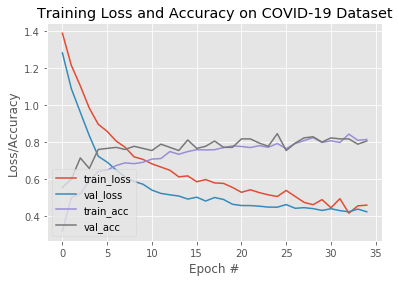

In [24]:
# plot the training loss and accuracy
N = 35
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

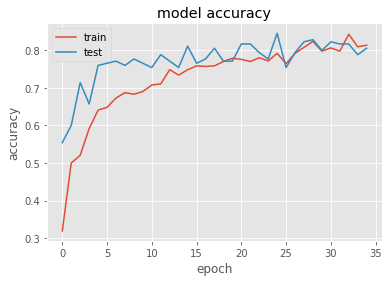

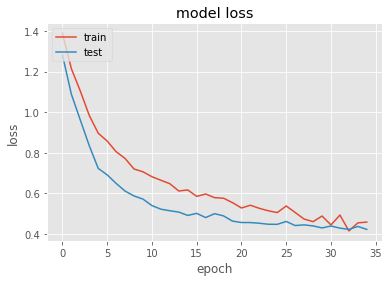

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.savefig('plot2.png', dpi=1000, bbox_inches='tight')


In [26]:
# make predictions on the testing set
predIdxs = model_2.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY, predIdxs, target_names=['covid','pnemonia_virus','pnemonia_bacteria','normal']))

                   precision    recall  f1-score   support

            covid       0.98      0.98      0.98        43
   pnemonia_virus       0.64      0.56      0.60        41
pnemonia_bacteria       0.71      0.73      0.72        44
           normal       0.86      0.94      0.90        47

         accuracy                           0.81       175
        macro avg       0.80      0.80      0.80       175
     weighted avg       0.80      0.81      0.80       175



In [27]:
cm = confusion_matrix(testY, predIdxs)
total = sum(sum(cm)) 
acc = (cm[0, 0] + cm[1, 1]+cm[2, 2]+cm[3,3]) / total
print("acc: {:.4f}".format(acc))

acc: 0.8057


Confusion matrix, without normalization
[[42  0  1  0]
 [ 0 23 11  7]
 [ 0 12 32  0]
 [ 1  1  1 44]]


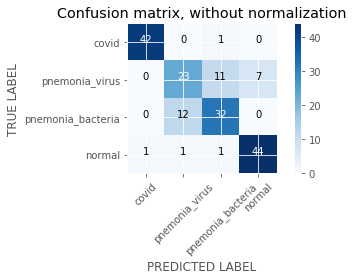

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('TRUE LABEL')
    plt.xlabel('PREDICTED LABEL')
    plt.tight_layout()
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['covid','pnemonia_virus','pnemonia_bacteria','normal'],
                      title='Confusion matrix, without normalization')

In [29]:
model_2.save('4classvgg')

INFO:tensorflow:Assets written to: 4classvgg/assets


In [30]:
from tensorflow.keras.models import save_model
save_model(model_2,filepath='./vggmodel',save_format='h5')